# Internal Tide and BALanced Turbulence: drifters

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt
import crocosi.drifters as cdr

In [2]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.224:8787/status,
Dashboard: http://10.148.0.224:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.224:56418,Workers: 0
Dashboard: http://10.148.0.224:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load data

In [14]:
#root_path = "/home/datawork-lops-osi/equinox/itbalt/"
#root_path = "/home1/scratch/aponte/"
root_path = "/home1/scratch/slgentil/" 

run = "fsturb_h500_a1_m0_4km_0a1000j"
run = "fsturb_h10000_a1_m0_4km_0a1000j"
#
#run = "fsturb_h500_a1_m1_4km_0a1000j"
#run = "fsturb_h10000_a1_m1_4km_0a1000j"

In [17]:
create_parquet = False
tdir_max = 5

if create_parquet:
    dr = cdr.drifter_dataframe(root_path+run, 
                               parquet=False, 
                               tdir_max=tdir_max,
                               index='id', 
                               persist=True,
                              )
    dr.store_parquet(overwrite=True)
else:
    dr = cdr.drifter_dataframe(root_path+run, 
                               index='id',
                               persist=True,
                              )

In [18]:
# load eulerian data
r = pp.Run(root_path+run, outputs=["surf", "his", "sec"], 
           tdir_max=tdir_max,
           chunks=dict(sec=dict(time=2400, s_rho=1)),
           grid_periodicity=True, verbose=1)
for o in ["surf", "his", "sec"]:
    r[o] = r[o].assign_coords(time=r[o].time_counter)

pout = r.params_output

Analysing directory /home1/scratch/slgentil/fsturb_h10000_a1_m0_4km_0a1000j
Found 5 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / surf / his / sec
Grid size: (L ,M, N) = (258, 722, 50)


In [19]:
# bins along y
binsize = 50
y_bins = np.arange(min(r["grid"].y_rho)/1e3, max(r["grid"].y_rho)/1e3, binsize)
#y_idx = pd.IntervalIndex.from_breaks(y_bins)

df = dr.df
df["y_cut"] = df["y"].map_partitions(pd.cut, bins=y_bins)

---

## basic diagnostics from drifters: density, kinetic energy

In [7]:
df_stats = df.groupby("y_cut").aggregate(['mean', 'std', 'count']).compute()
#df_stats.head()

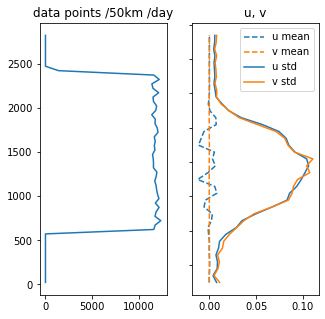

In [8]:
_df = df_stats.set_index(df_stats.index.map(lambda i: i.mid))

fig, axes = plt.subplots(1,2, figsize=(5,5))

ax = axes[0]
scale = 1/(df.time.max() - df.time.min()).compute()
ax.plot(_df["time"]["count"]*scale, _df.index)
ax.set_title("data points /50km /day")

ax = axes[1]
ax.plot(_df["u"]["mean"], _df.index, ls="--", label="u mean")
ax.plot(_df["v"]["mean"], _df.index, ls="--", label="v mean")
ax.set_prop_cycle(None)
ax.plot(_df["u"]["std"], _df.index, label="u std")
ax.plot(_df["v"]["std"], _df.index, label="v std")
ax.set_yticklabels([])
ax.set_title("u, v")
ax.legend()


Compare with Eulerian stats

In [9]:
ds_mean = r["surf"].mean(["time", "x_u", "x_rho"]).compute()
ds_std = r["surf"].std(["time", "x_u", "x_rho"]).compute()

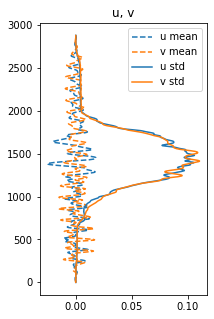

In [10]:
fig, axes = plt.subplots(1,1, figsize=(3,5))

ax = axes
ax.plot(ds_mean["u"], ds_mean.y_rho/1e3, ls="--", label="u mean")
ax.plot(ds_mean["v"], ds_mean.y_v/1e3, ls="--", label="v mean")
ax.set_prop_cycle(None)

ax.plot(ds_std["u"], ds_mean.y_rho/1e3, label="u std")
ax.plot(ds_std["v"], ds_mean.y_v/1e3, label="v std")
#ax.set_yticklabels([])
ax.set_title("u, v")
ax.legend()

---

## compute spectra

In [20]:
day2min = 24*60

def wrap_spectrum(df, T, dt, L, y_bins, **kwargs):
    """
    T: in days
    dt: in minutes
    """
    N = int(T*day2min/dt)
    print("Time window length in number of points N={}".format(N))
    df_chunked = (df
                  .groupby(df.index)
                  .apply(cdr.time_window_processing,
                         cdr.get_spectrum, 
                         ["ui"],
                         T, N, L, 
                         dt=dt/day2min,
                         **kwargs
                        )
                  .persist()
                 )
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    
    # average spectra in bins
    df_binned = df_chunked.groupby(['y_cut']).mean().compute()

    Euv = (pd.melt(df_binned.set_index(df_binned.index.map(lambda v: v.mid))
                  .drop(columns=['time','x','y','id'])
                  .reset_index()
                , id_vars=['y_cut'], var_name='frequency')
          .rename(columns={'y_cut': 'y', 'value': 'Euv'})
          .set_index(['y','frequency'])
          .to_xarray()
         )    
    
    return Euv

# compute dt
def get_dt(df, subsample=1):
    """ return dt in minutes
    """
    _df = df.groupby(df.index).get_group(1).compute()
    dt = (_df
          .sort_values("time")["time"]
          .iloc[::subsample]
          .diff()
          .median()
         )
    return round(dt*day2min)

In [21]:
# run computation over the whole dateset
T = 40 # window size
subsample = 2 # temporal subsampling
dt = get_dt(df, subsample=subsample)
print("dt = {} min".format(dt))
#
L = float(r["grid"].x_rho.max()/1e3) # km

df = dr.df
df['ui'] = df.u + 1j*df.v

ds_E = wrap_spectrum(df, T, dt, L, y_bins, subsample=subsample)

dt = 60 min
Time window length in number of points N=960


/dev/shm/pbs.7616416.datarmor0/ipykernel_10130/2240574577.py:10: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


In [22]:
diag_name = "spectra_uv_lagrangian_dt{}".format(dt)
r.store_diagnostic(diag_name, ds_E, overwrite=True)

data stored in /home1/scratch/slgentil/fsturb_h10000_a1_m0_4km_0a1000j/diagnostics/spectra_uv_lagrangian_dt60.zarr


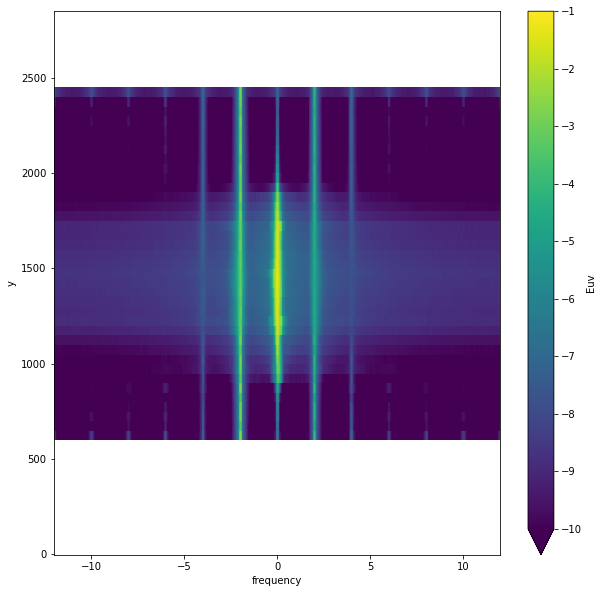

In [13]:
np.log10(ds_E.Euv).plot(vmin=-10, vmax=-1, figsize=(10,10))

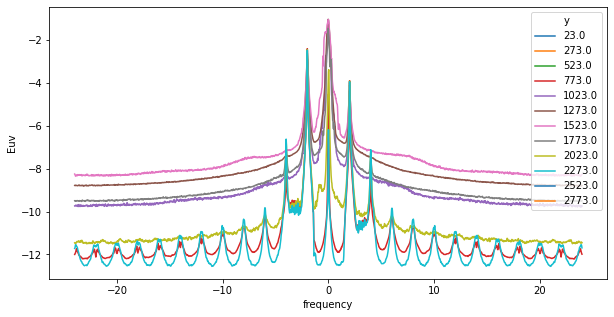

In [21]:
np.log10(ds_E.Euv.isel(y=slice(0,None,5))).plot(hue="y", figsize=(10,5));

--- 
### inspect single trajectory

In [32]:
_df = df.groupby(df.index).get_group(357).compute()

p = _df.sort_values('time')#.set_index('time')
p = p.where(p.time.diff()!=0).dropna()
p = p.set_index('time')
tmin, tmax = p.index[0], p.index[-1]
p.head()

,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,y_cut,ui
time,,,,,,,,,,,,,,
0.020833,20.974150,234.78093,50.0,-9.788341e-13,1000.0000,-6.521995e-10,3.912379e-10,-7.128589e-13,4.463217e-13,35.600622,83.896600,939.12372,"(898.0, 948.0]",-6.521995e-10+3.912379e-10j
0.041667,20.974150,234.78093,50.0,-2.656151e-11,1000.0000,-2.715337e-09,1.849618e-09,-1.434616e-12,1.081267e-12,35.600622,83.896600,939.12372,"(898.0, 948.0]",-2.715337e-09+1.849618e-09j
0.062500,20.974150,234.78093,50.0,-6.288667e-11,1000.0000,-5.923010e-09,4.504005e-09,-2.010457e-12,1.754691e-12,35.600622,83.896600,939.12372,"(898.0, 948.0]",-5.923010e-09+4.504005e-09j
0.083333,20.974150,234.78093,50.0,-1.107868e-10,1000.0000,-1.002616e-08,8.334373e-09,-2.454725e-12,2.380121e-12,35.600622,83.896600,939.12372,"(898.0, 948.0]",-1.002616e-08+8.334373e-09j
0.104167,20.974150,234.78093,50.0,-1.290189e-10,1000.0000,-1.483435e-08,1.313731e-08,-2.818271e-12,2.846320e-12,35.600622,83.896600,939.12372,"(898.0, 948.0]",-1.483435e-08+1.313731e-08j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499.916670,1.529702,260.80289,50.0,4.652419e-03,1000.0107,-1.779380e-02,2.430960e-02,4.927071e-07,1.506867e-06,35.646674,6.118808,1043.21156,"(998.0, 1048.0]",-1.779380e-02+2.430960e-02j
499.937500,1.521732,260.81425,50.0,4.710449e-03,1000.0107,-1.663008e-02,2.675277e-02,7.402946e-07,1.251856e-06,35.647244,6.086929,1043.25700,"(998.0, 1048.0]",-1.663008e-02+2.675277e-02j
499.958330,1.514291,260.82662,50.0,4.744431e-03,1000.0107,-1.506496e-02,2.865125e-02,9.445047e-07,9.106269e-07,35.647577,6.057165,1043.30648,"(998.0, 1048.0]",-1.506496e-02+2.865125e-02j


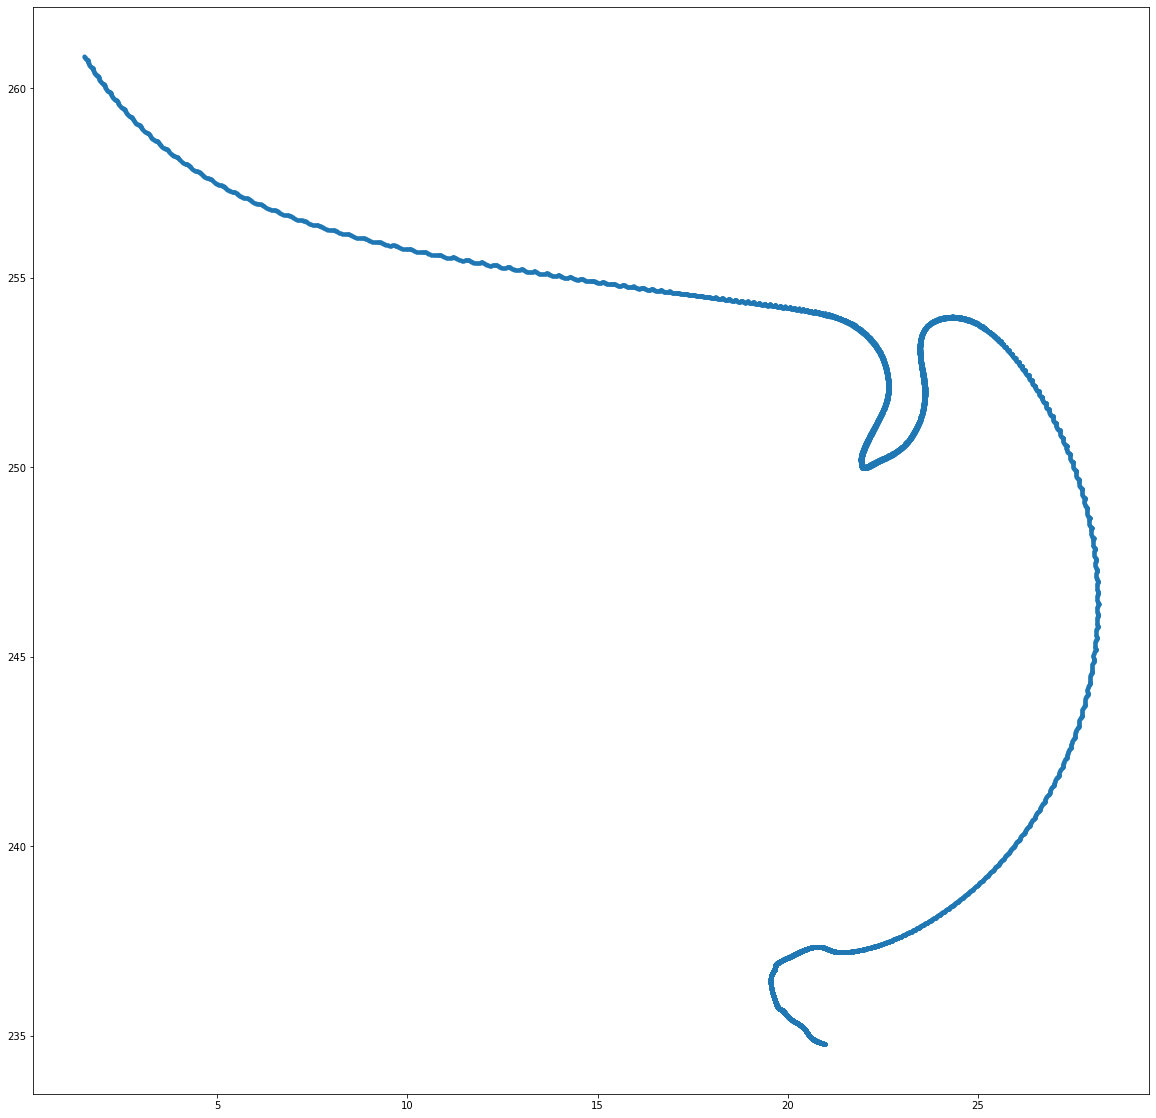

In [36]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.plot(p.xgrid, p.ygrid, '.')

---

In [23]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 